In [65]:
import collections
import functools
import itertools
import importlib
import json
import random
import requests
import multiprocessing
import os

import geojson

import geopandas as gpd

import numpy as np

import pandas as pd

import shapely

from backend.config import config
from backend.lib.fetch import representative_points
from backend.lib.database.postgres import connect
from backend.lib.calculate import adequacy, gravity

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.colors as colors

try:
    import seaborn as sns
except ModuleNotFoundError:
    !pip install seaborn
    import seaborn as sns

from statsmodels.stats import weightstats

%matplotlib inline
plt.rcParams['figure.figsize'] = (16, 12)
pd.set_option('max_columns', 999)
plt.style.use('seaborn-deep')

In [13]:
VARIABLES = []
GDFS = []
MMS = []

In [2]:
DATASET_DIRECTORY = '/usr/src/app/src/constants/datasets/'
DATASET_PATHS = [DATASET_DIRECTORY + x for x in os.listdir('/usr/src/app/src/constants/datasets/')]
DATASETS = []
for path in DATASET_PATHS:
    with open(path, 'r') as f:
        DATASETS.append(json.load(f))

In [24]:
ALL_SERVICE_AREAS = requests.get('https://encompass.bayesimpact.org/api/available-service-areas/').json()

def setup_variables(dataset):
    service_area_ids = [sa[0] for sa in ALL_SERVICE_AREAS if sa[3] == dataset['state'].upper()]
    raw_points = representative_points.minimal_fetch_representative_points(
        service_area_ids=service_area_ids,
    )
    return {
        'name': dataset['name'],
        'service_area_ids': service_area_ids,
        'providers': dataset['providers'],
        'points': raw_points
    }

In [4]:
# DATASET_VARIABLES = [setup_variables(dataset) for dataset in DATASETS]
variables = setup_variables(DATASETS[0]) 

In [147]:
def calculate_gravities(
    service_area_ids,
    providers,
    points,
    name='',
    measurer_name='haversine',
    decay_function=None,
    measurement_matrix=None,
    **kwargs
):
    if decay_function is None:
        if 'Health Centers' in name:
            sigma = 45.*0.5*1609
        if 'Endocrinologists' in name:
            sigma = 90.*0.5*1609
        decay_function=functools.partial(gravity.gaussian_decay, sigma=sigma)

    locations = [
        {
            'id': idx,
            'latitude': provider['lat'],
            'longitude': provider['lng']
        } for idx, provider in enumerate(providers)
    ]
    if measurement_matrix is None:
        measurement_matrix = gravity.calculate_measurement_matrix(
            service_area_ids=service_area_ids,
            locations=locations,
            measurer_name=measurer_name,
        )

    gravities = gravity.calculate_accessibility_indexes(
        measurement_matrix=measurement_matrix,
        points=points,
        decay_function=decay_function
    )
    for point, grav in zip(points, gravities):
        point['gravity'] = grav
    df = pd.DataFrame.from_records(points)
    
    df['closest_measurement'] = (-1)*np.min(measurement_matrix, axis=1)
    df['geometry'] = [
        shapely.geometry.Point(point) 
        for point in df[['longitude', 'latitude']].values
    ]
    gdf = gpd.GeoDataFrame(df)
    gdf.crs = {'init': 'espg:4326'}
    return gdf, measurement_matrix


def plot_access(gdf, column_name='gravity', log=False):
    stats = weightstats.DescrStatsW(gdf['gravity'].values, weights=gdf['population'], ddof=0)
    m = stats.mean
    s = stats.std
    
    gdf.plot(
        column=column_name,
        cmap='nipy_spectral',
        norm=colors.LogNorm(vmin=gdf[column_name].min(), vmax=gdf[column_name].max()) if log else None, 
        alpha=0.5,
        legend=True,
    )

In [50]:
for idx, ds in enumerate(DATASETS[:-1]):
    variables = setup_variables(ds)
    try:
        gdf, mm = calculate_gravities(**variables, measurement_matrix=MMS[idx])
        VARIABLES[idx] = variables
        GDFS[idx] = gdf
    except IndexError:
        gdf, mm = calculate_gravities(**variables)
        VARIABLES.append(variables)
        GDFS.append(gdf)
        MMS.append(mm)

Health Centers in Mississippi


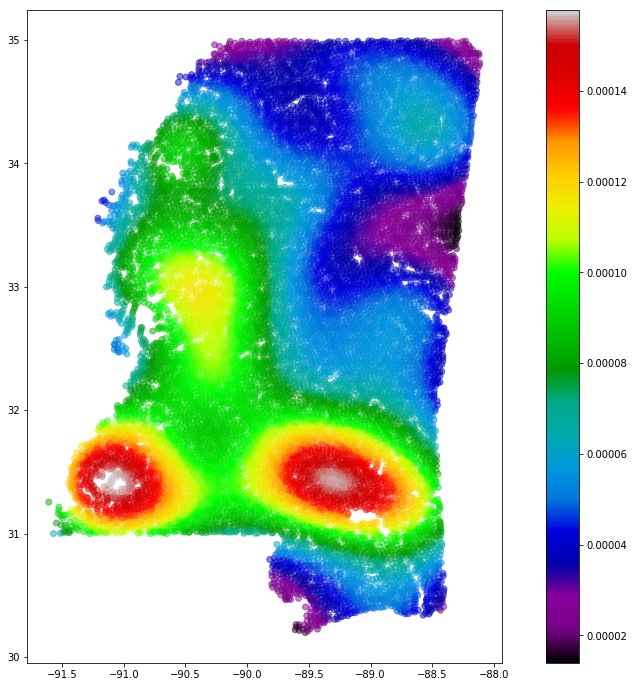

In [148]:
print(VARIABLES[2]['name'])
plt.rcParams['figure.figsize'] = (16, 12)
fig = plot_access(GDFS[2], log=False)

Endocrinologists in Florida


8.633588530271615e-05

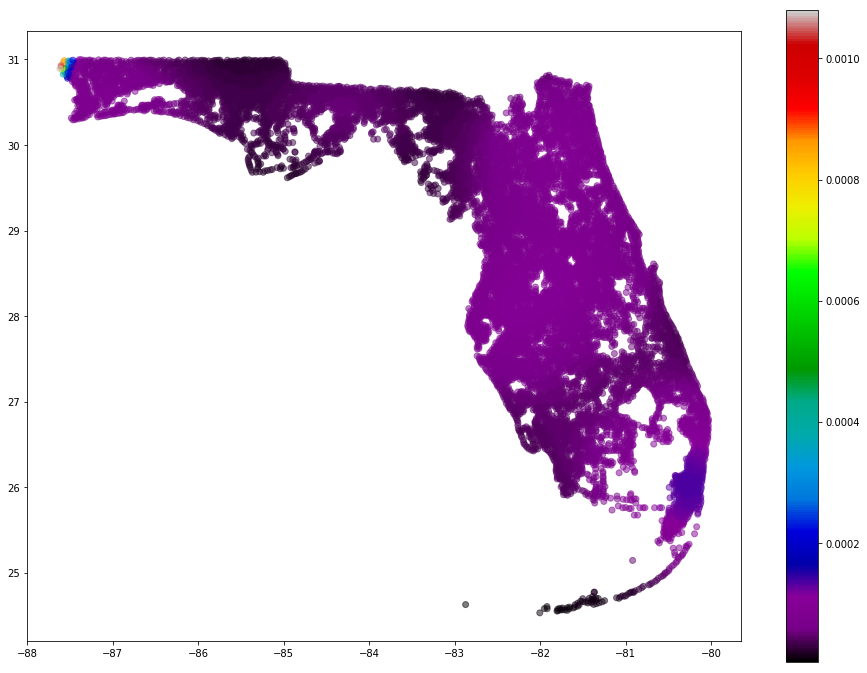

In [149]:
print(VARIABLES[0]['name'])
plt.rcParams['figure.figsize'] = (16, 12)
fig = plot_access(GDFS[0], log=False)
np.sum(GDFS[0]['gravity'].values * GDFS[0]['population'].values) / np.sum(GDFS[0]['population'].values)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fcb89fa22b0>]],
      dtype=object)

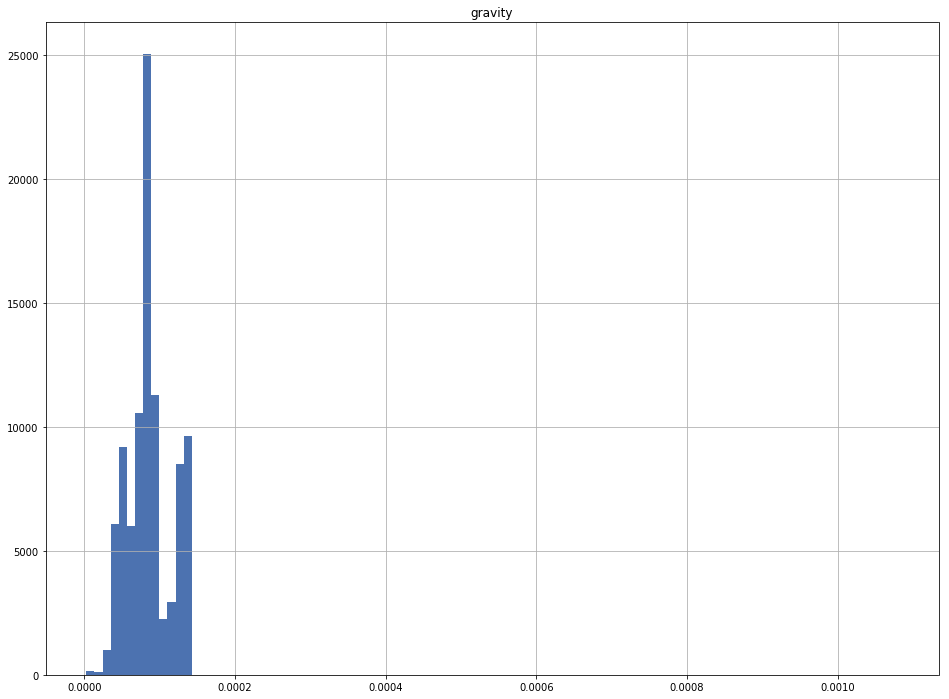

In [150]:
GDFS[0].hist(column='gravity', bins=100, weights=GDFS[0]['population'].values, normed=True)

Health Centers in Florida


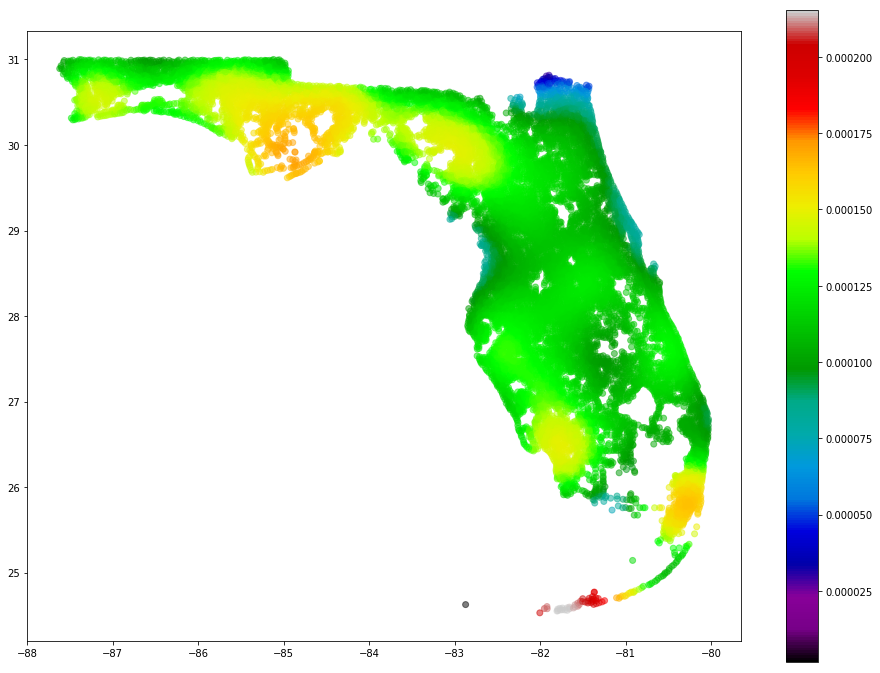

In [151]:
print(VARIABLES[1]['name'])
plt.rcParams['figure.figsize'] = (16, 12)
fig = plot_access(GDFS[1], log=True)

Health Centers in Florida


3.166798302889132e-05

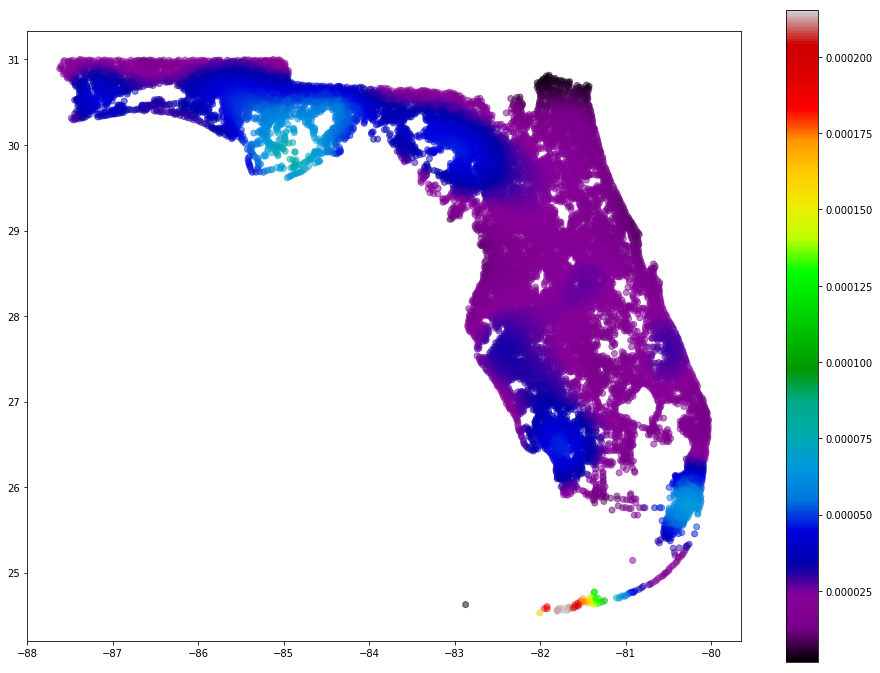

In [152]:
gdf = GDFS[1]
print(VARIABLES[1]['name'])
plt.rcParams['figure.figsize'] = (16, 12)
fig = plot_access(gdf, log=False)
np.sum(gdf['gravity'].values * gdf['population'].values) / np.sum(gdf['population'].values)

In [220]:
def access_by_standard_dev(val, mu, std, cutoffs):
    for idx, cutoff in enumerate(cutoffs):
        if val > mu + std*cutoff:
            continue
        else:
            return cutoff
        
def access_as_multiple_of_mean(val, mu):
    return min(val / mu, 3.0)

In [227]:
def plot_access2(gdf, column_name='gravity', log=False):
    stats = weightstats.DescrStatsW(gdf[column_name].values, weights=gdf[column_name], ddof=0)
    mu = stats.mean
    std = stats.std
    gdf['access'] = gdf['gravity'].apply(lambda x: access_as_multiple_of_mean(x, mu))
    gdf.plot(
        column='access',
        cmap=plt.cm.get_cmap('Accent', 5),
        norm=colors.Normalize(vmin=gdf['gravity'].min(), vmax=gdf['gravity'].max() / 2),
        alpha=0.5,
        legend=True,
    )

3.166798302889132e-05

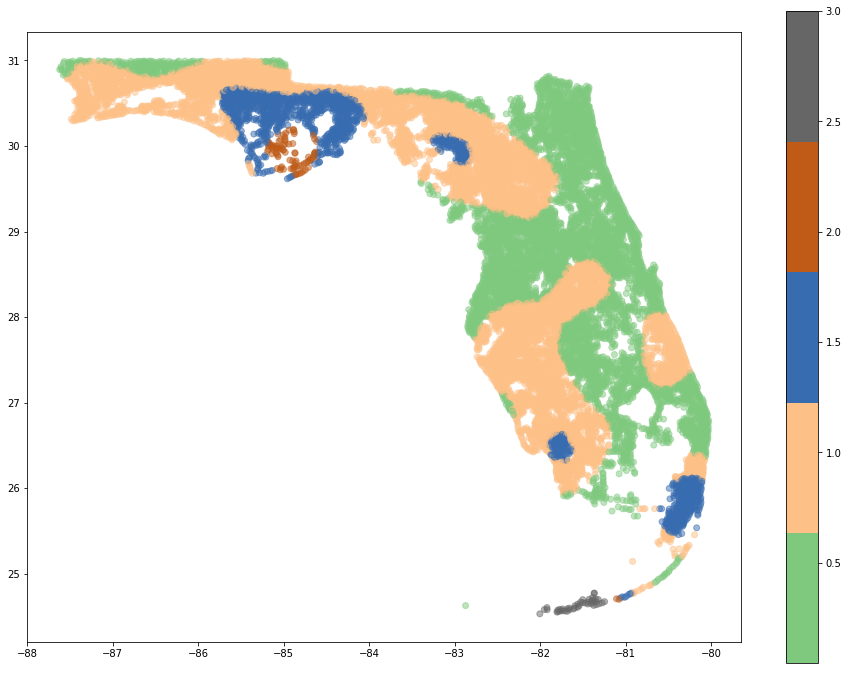

In [228]:
gdf = GDFS[1]
plt.rcParams['figure.figsize'] = (16, 12)
fig = plot_access2(gdf, log=False)
np.sum(gdf['gravity'].values * gdf['population'].values) / np.sum(gdf['population'].values)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fcb94d4fc18>]],
      dtype=object)

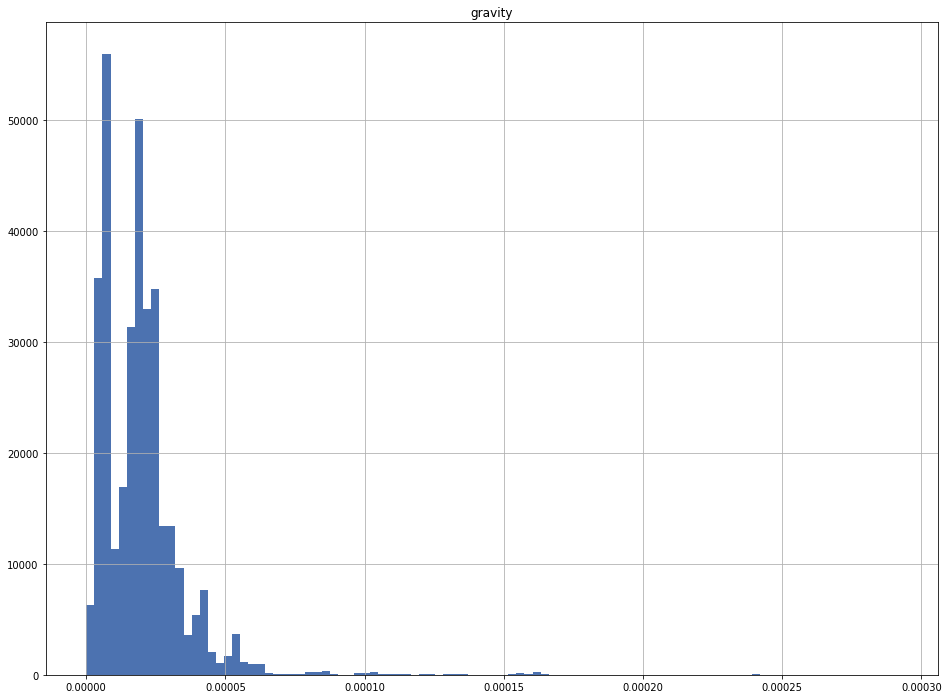

In [156]:
gdf.hist(column='gravity', bins=100, weights=gdf['population'].values, normed=True)

In [174]:
def plot_access3(gdf, column_name='gravity', log=False):
    stats = weightstats.DescrStatsW(gdf['gravity'].values, weights=gdf['population'], ddof=0)
    m = stats.mean
    s = stats.std
    
    gdf.plot(
        column=column_name,
        cmap='nipy_spectral',
        norm=colors.Normalize(vmin=gdf['gravity'].min(), vmax=gdf['gravity'].max() / 200, clip=True),
        alpha=0.5,
        legend=True,
    )

In [162]:
norm=colors.Normalize(vmin=gdf['gravity'].min(), vmax=gdf['gravity'].max() / 10, clip=True)

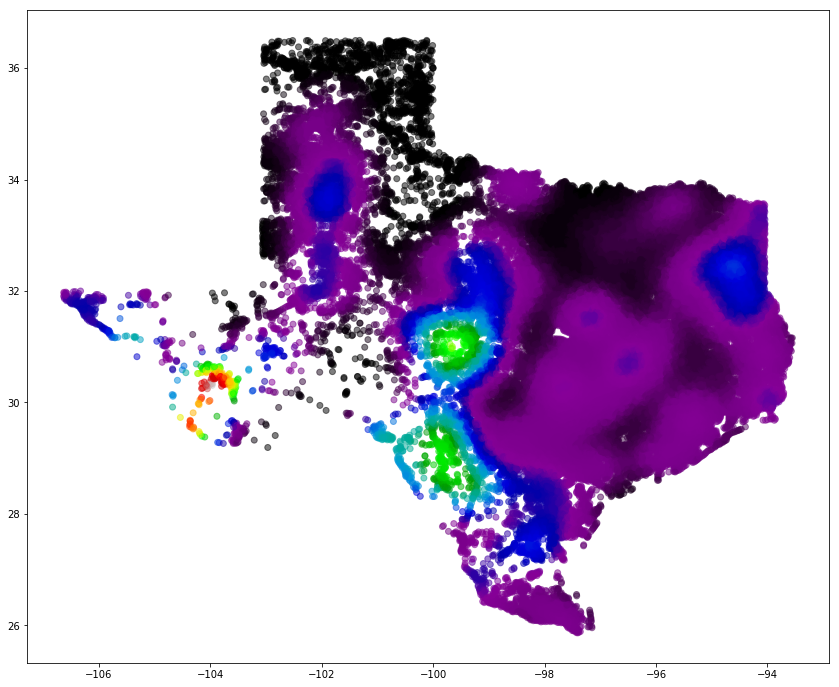

In [178]:
gdf.plot(
    column='gravity',
    cmap='nipy_spectral',
    norm=colors.Normalize(vmin=gdf['gravity'].min(), vmax=gdf['gravity'].max() / 200, clip=True),
    alpha=0.5,
    legend=True
)

In [188]:
plt.scatter?